# Module 3: Time Series Decomposition Assignment
Jason Merten

### Assignment Desired Outcomes:

Decompose the private and public spending data series from the ConstructionTimeSeriesv2.csv file using the most appropriate of the two time series decomposition methods that were demonstrated in the lecture videos.

### Requirements

For each of the two data series:
- Compute the squared error for your model relative to the original data series for each month, and cumulatively as well.
- Compute a pandas column named R2X that shows the error of your model relative to the original data series, where X is replaced by either Public or Private for the respective analyses.
- Compute a pandas column named R2ErrorX that shows R2 relative to (divided by) the original data series.

### Environment Setup

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline
from os import getcwd 
print(getcwd())

C:\Users\jmert\Documents\W&M\BUAD5112\M3


### Read the Data

During this step, I decided that it would be best to rename the columns to make it easier with autocompletion throughout the file.  Additionally, I decided to conver the Date column to datetime since we are working with a time series data set.  Finally, I dropped the Month column as it didn't provide any useful information that couldn't already be extracted from existing data or the index.

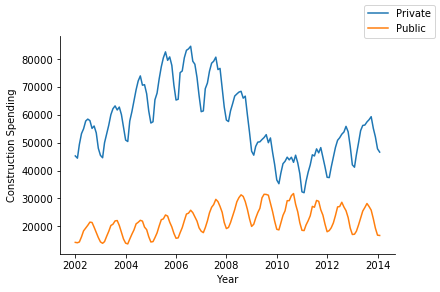

In [2]:
data = pd.read_csv('ConstructionTimeSeriesDataV2.csv')
data.rename(columns={'Month-Year':'Date','Total Construction':'Total','Private Construction':'Private','Public Construction':'Public'},inplace=True)
data.Date = '1-'+data.Date
data.Date = pd.to_datetime(data.Date,dayfirst=True)
data.drop(['Month'],axis=1,inplace=True)

fig,ax = plt.subplots()
ax.plot(data.Date,data.Private,label='Private')
ax.plot(data.Date,data.Public,label='Public')
ax.set_xlabel('Year')
ax.set_ylabel('Construction Spending')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()

### Initial Analysis

To keep the total number of cells to a minimum, I created unique formulas for the Private and Public data sets.  Where possible I tried to do all calculations and transformations within the same for loops.  The initial analysis was to find the correct Moving Average window for each data subset by determining which window had the lowest squared error.

Average Private Squared Error 71294653.93589342
Average Public Squared Error 14316799.922417827


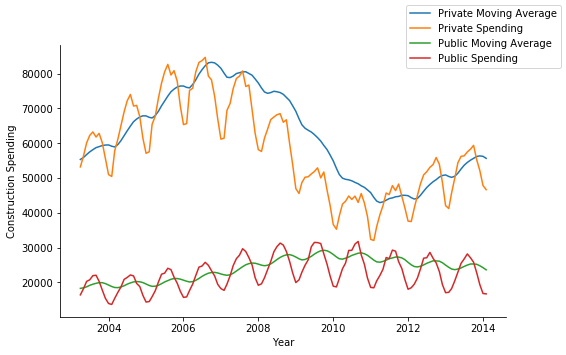

In [3]:
def prisqErr(row):
    return (row['Private'] - row['Pri_MovAvg'])**2
def pubsqErr(row):
    return (row['Public'] - row['Pub_MovAvg'])**2

data['Pri_MovAvg'] = np.NaN 
data['Pri_sqErr'] = np.NaN
data['Pub_MovAvg'] = np.NaN
data['Pub_sqErr'] = np.NaN

data.set_index('Date')

window = 14
window = window - window % 2

for i in range(window+1,len(data)):
    data.loc[data.index[i],'Pri_MovAvg'] = sum(data.iloc[range(i-window-1,i)]['Private'])/float(window)
    data.loc[data.index[i],'Pub_MovAvg'] = sum(data.iloc[range(i-window-1,i)]['Public'])/float(window)

data['Pri_sqErr'] = data.apply(prisqErr,axis='columns')
data['Pub_sqErr'] = data.apply(pubsqErr,axis='columns')

data.dropna(how='any',axis=0,inplace=True)

fig,ax = plt.subplots(figsize=(8,5))
ax.plot(data.Date,data.Pri_MovAvg,label='Private Moving Average')
ax.plot(data.Date,data.Private,label='Private Spending')
ax.plot(data.Date,data.Pub_MovAvg,label='Public Moving Average')
ax.plot(data.Date,data.Public,label='Public Spending')
ax.set_xlabel('Year')
ax.set_ylabel('Construction Spending')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.legend()
print('Average Private Squared Error',sum(data.Pri_sqErr)/len(data.index))
print('Average Public Squared Error', sum(data.Pub_sqErr)/len(data.index))



Below are tables for the Private and Public squared errors for all windows tested.  Based on the results, a Moving Average window of 14 provides the lowest error compared to the other window sizes for both data subsets.

**Private Squared Error**

window | sqErr
--- | ---
2  | 914910975
4  | 278612959
6  | 164973401
8  | 119482220
10 | 90377681
12 | 72830695
14 < | 71294653
16 | 79832820

**Public Squared Error**

window | sqErr
--- | ---
2  | 144794847
4  | 55640270
6  | 40081705
8  | 30343827
10 | 21379236
12 | 15405036
14 < | 14316799
16 | 16808864

### Calculating the first Residuals

This next section will calculate the first residuals for both sets of data.  I also took the time to format the data outputs into floats to help with readability when the whole data set is printed out.


Average Private Residual:  -4065.959651035987
Average Public Residual:  -1302.6608505997817


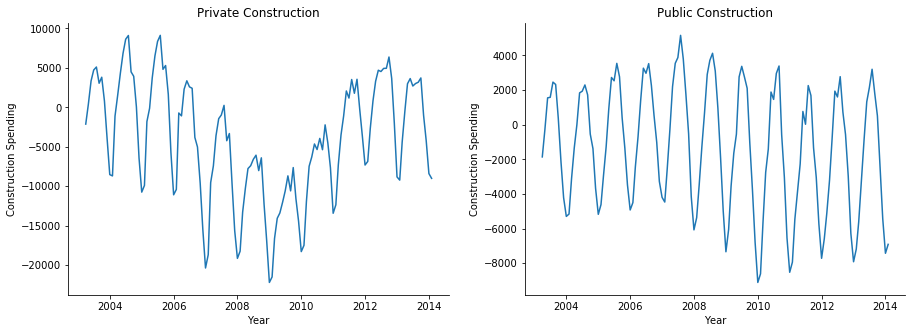

In [4]:
# Private R1
data['R1Private'] = data.Private - data.Pri_MovAvg
data['R1PrivateErr']= abs((data.Private - data.R1Private/data.Private))

# Public R1
data['R1Public'] = data.Public - data.Pub_MovAvg
data['R1PublicErr'] = abs((data.Public - data.R1Public/data.Public))
data.style.format({
    'Pri_MovAvg':'{:,.1f}'.format,
    'Pri_sqErr':'{:,.1f}'.format,
    'Pub_MovAvg':'{:,.1f}'.format,
    'Pub_sqErr':'{:,.1f}'.format,
    'R1Private':'{:,.1f}'.format,
    'R1PrivateErr':'{:,.3f}'.format,
    'R1Public':'{:,.1f}'.format,
    'R1PublicErr':'{:,.3f}'.format
})
# data
fig,axes = plt.subplots(1,2,figsize=(15,5))
axes[0].plot(data.Date,data.R1Private,label='Private Remainder After Trend')
axes[1].plot(data.Date,data.R1Public,label='Public Remainder After Trend')
axes[0].set_title('Private Construction')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Construction Spending')
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[1].set_title('Public Construction')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Construction Spending')
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
print('Average Private Residual: ',sum(data.R1Private)/len(data))
print('Average Public Residual: ',sum(data.R1Public)/len(data))

### First Redisual Maximum Correlation

The next two code chunks will find the maximum correlation lag for each data subset.  To do this, I created two correlation and period variables for the Private and Public data subsets and tested each lag against the previous lags to find the maximum.

In [5]:
pri_maxCorr,pub_maxCorr = 0.0,0.0
pri_period,pub_period = np.NaN,np.NaN
for i in range(1,37):
    pri_corr = data.R1Private.autocorr(lag=i)
    pub_corr = data.R1Public.autocorr(lag=i)
    print('Private Correlation, lag',i,'  ',pri_corr)
    print('Public Correlation, lag',i,'  ',pub_corr)
    print('----------')
    if pri_corr > pri_maxCorr:
        pri_maxCorr = pri_corr
        pri_period = i
    if pub_corr > pub_maxCorr:
        pub_maxCorr = pub_corr
        pub_period = i
print('period = ',pri_period,'  Maximum Correlation (Private) = ',pri_maxCorr)
print('period = ',pub_period,'  Maximum Correlation (Public) = ',pub_maxCorr)

Private Correlation, lag 1    0.889118249185397
Public Correlation, lag 1    0.8558336110901543
----------
Private Correlation, lag 2    0.6795183012002465
Public Correlation, lag 2    0.5152957400346849
----------
Private Correlation, lag 3    0.4399918211902559
Public Correlation, lag 3    0.061942124377643654
----------
Private Correlation, lag 4    0.24729968801011898
Public Correlation, lag 4    -0.38939343872277826
----------
Private Correlation, lag 5    0.1162485708025346
Public Correlation, lag 5    -0.7018483403358841
----------
Private Correlation, lag 6    0.043791994437863795
Public Correlation, lag 6    -0.8158732596586059
----------
Private Correlation, lag 7    0.079256792714192
Public Correlation, lag 7    -0.7075691644655372
----------
Private Correlation, lag 8    0.1791210461467031
Public Correlation, lag 8    -0.39473392659500345
----------
Private Correlation, lag 9    0.34597234949333705
Public Correlation, lag 9    0.051010520394330836
----------
Private Correla

Interestingly, the maximum correlation was found on lag 1 for the Private data subset which was unexpected.  I'm not exactly sure why the first lag turned out that way (my first thought is that the data isn't as linear as the Public data), but the cyclicality of the data should lead us to expect that lag 12 will have the highest correlation like we saw with the Public data set.

### Computation of the Cyclic Component

The below code computes the cyclic component of the time series data and plots it against the R1 value that we calulated previously to check to see how well the patterns fit.  For the graphs, we aren't necessarily looking to have an exact fit with the data, just that the cycles line up.  

- On a side note, I needed to modify the Private cycle length to 12 based on the findings from above.

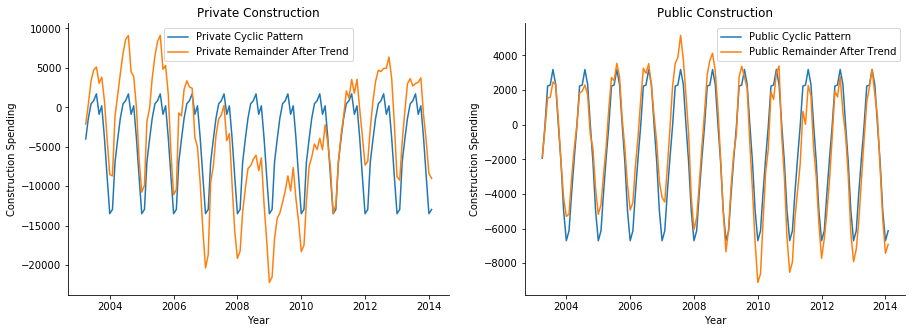

In [6]:
pri_cycleLen,pub_cycleLen = 12,pub_period
pri_avg = []
pub_avg = []
pri_numCycles = int(len(data)/pri_cycleLen + 0.5)
pub_numCycles = int(len(data)/pub_cycleLen + 0.5)
for j in range(pri_cycleLen):
    if j + (pri_numCycles-1) * pri_cycleLen < len(data):
        d = data.iloc[range(j,j + (pri_numCycles-1) * pri_cycleLen+1,pri_cycleLen)]['R1Private']
        # print(j,d)
        pri_avg.append(sum(d)/len(d))
    else:
        d = data.iloc[range(j,j + (pri_numCycles-2) * pri_cycleLen+1,pri_cycleLen)]['R1Private']
        pri_avg.append(sum(d)/len(d))

for j in range(pub_cycleLen):
    if j + (pub_numCycles-1) * pub_cycleLen < len(data):
        d = data.iloc[range(j,j + (pub_numCycles-1) * pub_cycleLen+1,pub_cycleLen)]['R1Public']
        # print(j,d)
        pub_avg.append(sum(d)/len(d))
    else:
        d = data.iloc[range(j,j + (pub_numCycles-2) * pub_cycleLen+1,pub_cycleLen)]['R1Public']
        pub_avg.append(sum(d)/len(d))

data['pri_C'] = np.NaN
data['pub_C'] = np.NaN
for i in range(len(data)):
    data.loc[data.index[i],'pri_C'] = pri_avg[i % pri_cycleLen]
    data.loc[data.index[i],'pub_C'] = pub_avg[i % pub_cycleLen]

fig,axes = plt.subplots(1,2,figsize=(15,5))
axes[0].plot(data.Date,data.pri_C,label='Private Cyclic Pattern')
axes[0].plot(data.Date,data.R1Private,label='Private Remainder After Trend')
axes[1].plot(data.Date,data.pub_C,label='Public Cyclic Pattern')
axes[1].plot(data.Date,data.R1Public,label='Public Remainder After Trend')
axes[0].set_title('Private Construction')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Construction Spending')
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].legend()
axes[1].set_title('Public Construction')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Construction Spending')
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].legend()

Looking at the graphs, we can tell that the periods seem to fit very well for the cyclical component of our model.  As expected, the graph for the Private data doesn't exactly line up with the vertical oscillation of the data, but the patterns do match (peaks to peaks, troughs to troughs).

### Cycle Evaluation

The next graphs will take a look at how well each cycle matches the average cycle for both data subsets.

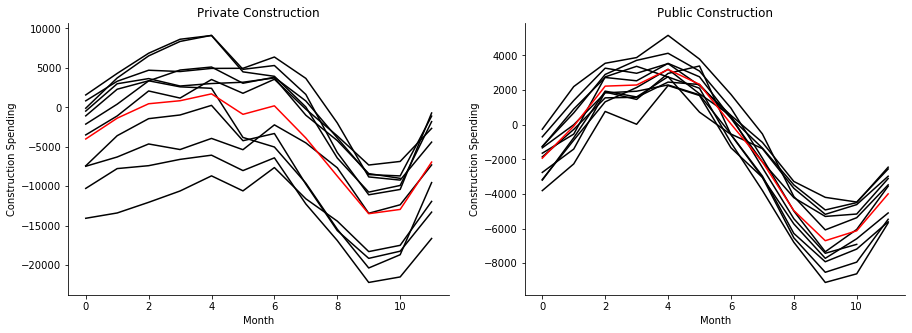

In [7]:
pri_period = 12
pri_cycles = [data.iloc[range(i*pri_period,min((i+1)*pri_period,len(data)))]['R1Private'] for i in range(pri_numCycles)]
pub_cycles = [data.iloc[range(i*pub_period,min((i+1)*pub_period,len(data)))]['R1Public'] for i in range(pub_numCycles)]

fig,axes = plt.subplots(1,2,figsize=(15,5))
for i in range(len(pri_cycles)):
    axes[0].plot(pri_cycles[i].values,label='Cycle '+str(i),c='k')
for i in range(len(pub_cycles)):
    axes[1].plot(pub_cycles[i].values,label='Cycle '+str(i),c='k')
axes[0].plot(pri_avg,label='Private Average Cycle',c='r')
axes[1].plot(pub_avg,label='Public Average Cycle',c='r')
axes[0].set_title('Private Construction')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Construction Spending')
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
# axes[0].legend()
axes[1].set_title('Public Construction')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Construction Spending')
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
# axes[1].legend()

The Private cycle evaluation graph looks a little looser because of the wide range of vertical oscillations for that data set.  The data seems to be following a sinusoidal pattern, but that is likely because of the 2007 housing bubble collapse.

### Second Residual Calculation

This next section will calculate the second residual for the data by subtracting the cyclical component from the original data, calculating the error, and finally calculating the fit (Moving Average plus cyclical component).  After all of the calculations are complete, we will calculate the overall error for the model and plot the original data with the fit model to get a visual feel.

Average Private Error:  0.08517701179727358
Average Public Error:  0.044733431033950506


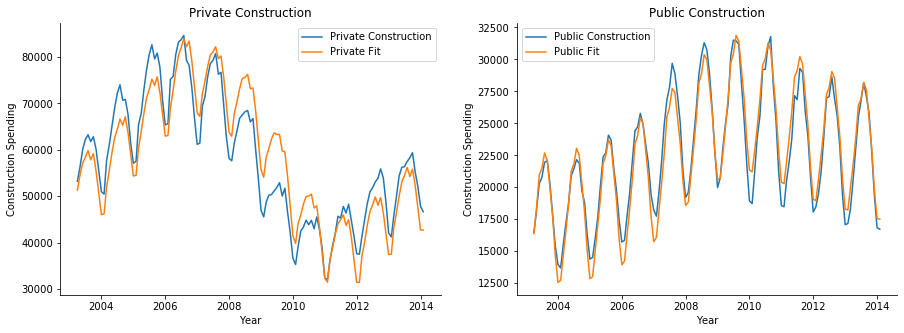

In [8]:
data['R2Private'] = data.R1Private - data.pri_C
data['R2ErrorPrivate'] = abs(data.R2Private/data.Private)
data['pri_fit'] = data.Pri_MovAvg + data.pri_C
data['R2Public'] = data.R1Public - data.pub_C
data['R2ErrorPublic'] = abs(data.R2Public/data.Public)
data['pub_fit'] = data.Pub_MovAvg + data.pub_C
print('Average Private Error: ',sum(data.R2ErrorPrivate)/len(data))
print('Average Public Error: ',sum(data.R2ErrorPublic)/len(data))

fig,axes = plt.subplots(1,2,figsize=(15,5))
axes[0].plot(data.Date,data.Private,label='Private Construction')
axes[0].plot(data.Date,data.pri_fit,label='Private Fit')
axes[1].plot(data.Date,data.Public,label='Public Construction')
axes[1].plot(data.Date,data.pub_fit,label='Public Fit')
axes[0].set_title('Private Construction')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Construction Spending')
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].legend()
axes[1].set_title('Public Construction')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Construction Spending')
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].legend()

Looking at the error rates for the data, 8.5% for Private and 4.4% for Public, we can say that the model did a pretty good job of emulating the data.  Visually, the Private model seemed to have a bit of trouble fitting exactly to the original data, but it is following the sinusoidal pattern and the yearly cyclical pattern.

### Second Residual Maximum Correlation

This next section will calculate the maximum correlation for the second residuals.

Private Correlation, lag 1    0.9725993841342541
Public Correlation, lag 1    0.874756885376103
----------
Private Correlation, lag 2    0.9414708375871478
Public Correlation, lag 2    0.7905613277654836
----------
Private Correlation, lag 3    0.903250471595238
Public Correlation, lag 3    0.7172567902083562
----------
Private Correlation, lag 4    0.8676916325081736
Public Correlation, lag 4    0.6019297796891179
----------
Private Correlation, lag 5    0.827610728447954
Public Correlation, lag 5    0.5470135290249567
----------
Private Correlation, lag 6    0.795076641358359
Public Correlation, lag 6    0.4996775263017794
----------
Private Correlation, lag 7    0.7730188397913379
Public Correlation, lag 7    0.4526737684093191
----------
Private Correlation, lag 8    0.7570109366788557
Public Correlation, lag 8    0.48101195498375565
----------
Private Correlation, lag 9    0.7372898950688319
Public Correlation, lag 9    0.5490394989864227
----------
Private Correlation, lag 10    

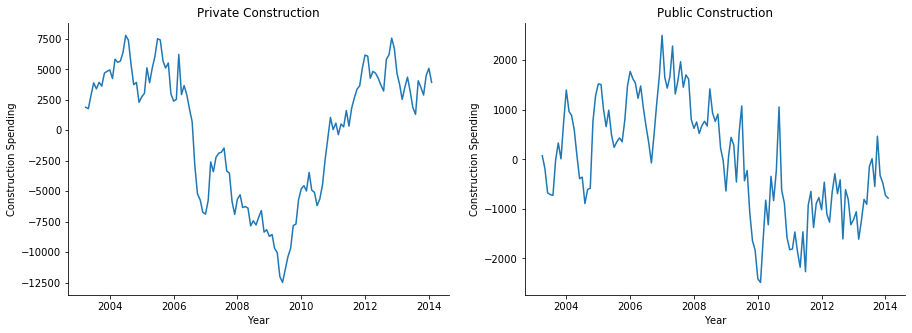

In [9]:
fig,axes = plt.subplots(1,2,figsize=(15,5))
axes[0].plot(data.Date,data.R2Private,label='Private Remainder after Trend/Cyclical')
axes[1].plot(data.Date,data.R2Public,label='Public Remainder after Trend/Cyclical')
axes[0].set_title('Private Construction')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Construction Spending')
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[1].set_title('Public Construction')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Construction Spending')
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)

pri_maxCorr,pub_maxCorr = 0.0,0.0
pri_period,pub_period = np.NaN,np.NaN
for i in range(1,37):
    pri_corr = data.R2Private.autocorr(lag=i)
    pub_corr = data.R2Public.autocorr(lag=i)
    print('Private Correlation, lag',i,'  ',pri_corr)
    print('Public Correlation, lag',i,'  ',pub_corr)
    print('----------')
    if pri_corr > pri_maxCorr:
        pri_maxCorr = pri_corr
        pri_period = i
    if pub_corr > pub_maxCorr:
        pub_maxCorr = pub_corr
        pub_period = i
print('period = ',pri_period,'  Maximum Correlation (Private) = ',pri_maxCorr)
print('period = ',pub_period,'  Maximum Correlation (Public) = ',pub_maxCorr)

The results of the second residual maximum correlation test indicate that there are no more components that we need to calculate to get a more accurate model.

### Final Combined Plot

The final plot will pull the original data, the fitted model, and the second residuals all into the same graph for use in presentations and further analysis.

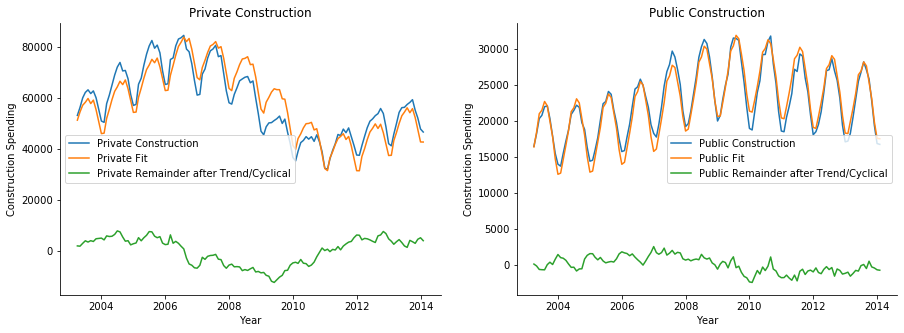

In [10]:
fig,axes = plt.subplots(1,2,figsize=(15,5))
axes[0].plot(data.Date,data.Private,label='Private Construction')
axes[0].plot(data.Date,data.pri_fit,label='Private Fit')
axes[0].plot(data.Date,data.R2Private,label='Private Remainder after Trend/Cyclical')
axes[1].plot(data.Date,data.Public,label='Public Construction')
axes[1].plot(data.Date,data.pub_fit,label='Public Fit')
axes[1].plot(data.Date,data.R2Public,label='Public Remainder after Trend/Cyclical')
axes[0].set_title('Private Construction')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Construction Spending')
axes[0].spines['right'].set_visible(False)
axes[0].spines['top'].set_visible(False)
axes[0].legend()
axes[1].set_title('Public Construction')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Construction Spending')
axes[1].spines['right'].set_visible(False)
axes[1].spines['top'].set_visible(False)
axes[1].legend()